In [ ]:
"""
Filename: main.ipynb
Author: Alexay Mehra
Date: 2025-09-12
Description: Main file for testing, contains the following:
- Image of the Morse Potential to fit
- Code block to run the optimization function
- Visuals to compare synthesized time evolution with true time evolution
"""

In [1]:
# Imports

import os, sys
sys.path.append(os.path.abspath("../src"))

import numpy as np
import scipy as sp
from qutip import coherent

import utils, optimization, visualization

**1. Define the Morse Potential Parameters:**
- *mass* = reduced mass of diatomic system
- *de* = well depth
- *b* = width parameter
- *x0* = equilibrium bond length
- *hbar* = reduced planck's constant (default 1 for easy units)

There are other values available based on these inputs:
- the *force constant* for the potential
- the *angular frequency* associated with the potential
- the *number of bounded states*
- the *maximum bounded quantum number*

In [ ]:
morse_potential = utils.MorsePotential(
    mass = 1,
    de = 1.0, 
    b = 0.5, 
    x0 = 0.5,
    hbar = 1
)

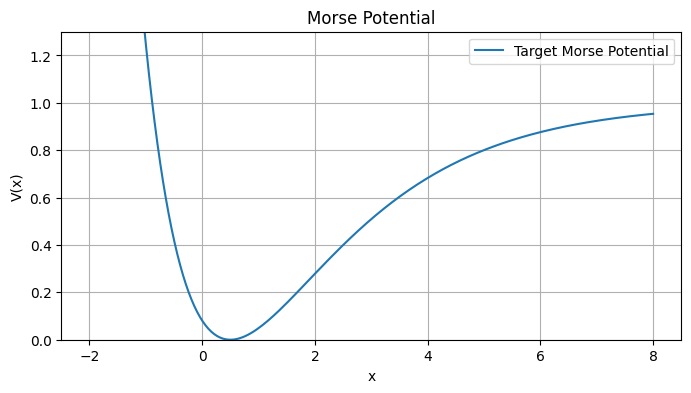

In [19]:
# Plot the Morse Potential
morse_potential.plot_potential()

**2. Create the Backend for Optimization**


In [14]:
# Select the size of the hilbert space and time to optimize over
backend = utils.Gates(
    dim = 10,
    time = 1
)

# Choose the gate depth to use
depth = 6

# Choose parameters for gates with configurable parameters not in the optimization
utils.AlwaysOnGate.config["omega"] = morse_potential.angular_freq
utils.AlwaysOnGate.config["chi"] = 0.01
utils.AlwaysOnGate.config["time"] = backend.time

# Choose the gate sequence to use
sequence_template = [
    utils.AlwaysOnGate,
    utils.RotationGate,
    utils.DisplacementGate
    ]    

# generate the time evolution you want to match
morse_evolution, *_ = backend.morse_time_evolution(morse_potential)

**3. Run the Chosen Optimization Function**

In [15]:
optimal_params = optimization.run_optimization(
    seq_template = sequence_template,
    backend = backend,
    d = depth,
    loss_function = optimization.fidelity_loss,
    target_evolution = morse_evolution,
    mode = 'coordinate-descent',
    max_iterations = 5
)

Optimized XY Rotation, Iteration 1
Current Infidelity: 0.929498

Optimized Displacement, Iteration 1
Current Infidelity: 0.709630

Optimized XY Rotation, Iteration 2
Current Infidelity: 0.696989

Optimized Displacement, Iteration 2
Current Infidelity: 0.696929

Optimized XY Rotation, Iteration 3
Current Infidelity: 0.696929

Optimized Displacement, Iteration 3
Current Infidelity: 0.696929

Optimized XY Rotation, Iteration 4
Current Infidelity: 0.696929

Optimized Displacement, Iteration 4
Current Infidelity: 0.696929

Optimized XY Rotation, Iteration 5
Current Infidelity: 0.696929

Optimized Displacement, Iteration 5
Current Infidelity: 0.696929



**4. Post Processing: Generate the Desired Visualizations**

In [16]:
# Build the synthesized unitary and extract the hamiltonian
synthesized_evolution = optimization.build_sequence(
    params = optimal_params,
    seq_template = sequence_template,
    backend = backend,
    d = depth
)
synthesized_hamiltonian = (1j / backend.time) * sp.linalg.logm(synthesized_evolution)

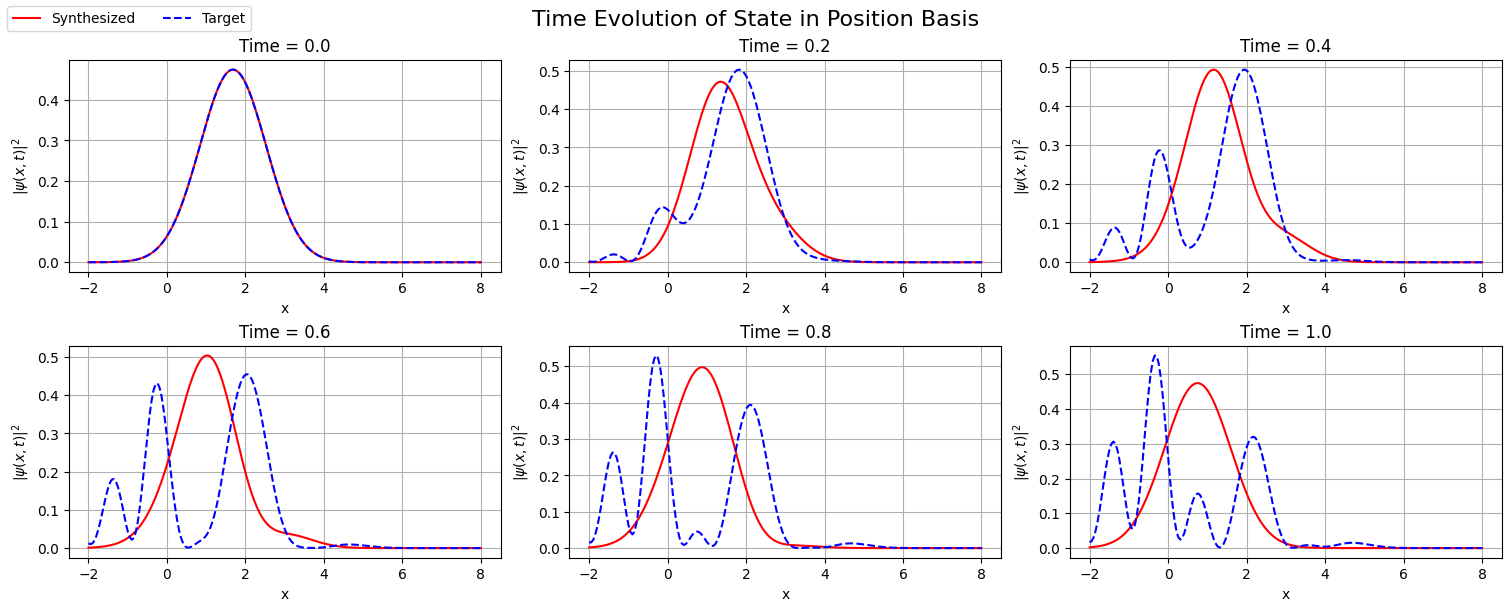

In [17]:
# Generate Wavefunction Graphics

target_time = 1 # End time to be visualized for the wavefunction
n_steps = 6     # number of time steps to visualize

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode

# Option 1: Fock state
#fock_state_index = 2
#init_qumode_state = np.zeros(N, dtype=complex)
#init_qumode_state[fock_state_index] = 1.0

# Option 2: Coherent state
from qutip import coherent
alpha = 1.0 + 0.5j
init_qumode_state = coherent(backend.dim, alpha).full().flatten()

# --- Generate Wavefunction Visualization ---
visualization.generate_wavefunc(
    init_qubit_state = init_qubit_state,
    init_qumode_state = init_qumode_state,
    target_time = target_time,
    n_steps = n_steps,
    gen_hamiltonian = synthesized_hamiltonian,
    backend = backend,
    morse_to_optimize = morse_evolution,
    mp = morse_potential
)

Fidelity at t = 0.00: 1.000000
Fidelity at t = 0.17: 0.955264
Fidelity at t = 0.33: 0.828865
Fidelity at t = 0.50: 0.644096
Fidelity at t = 0.67: 0.436217
Fidelity at t = 0.83: 0.245049
Fidelity at t = 1.00: 0.105155


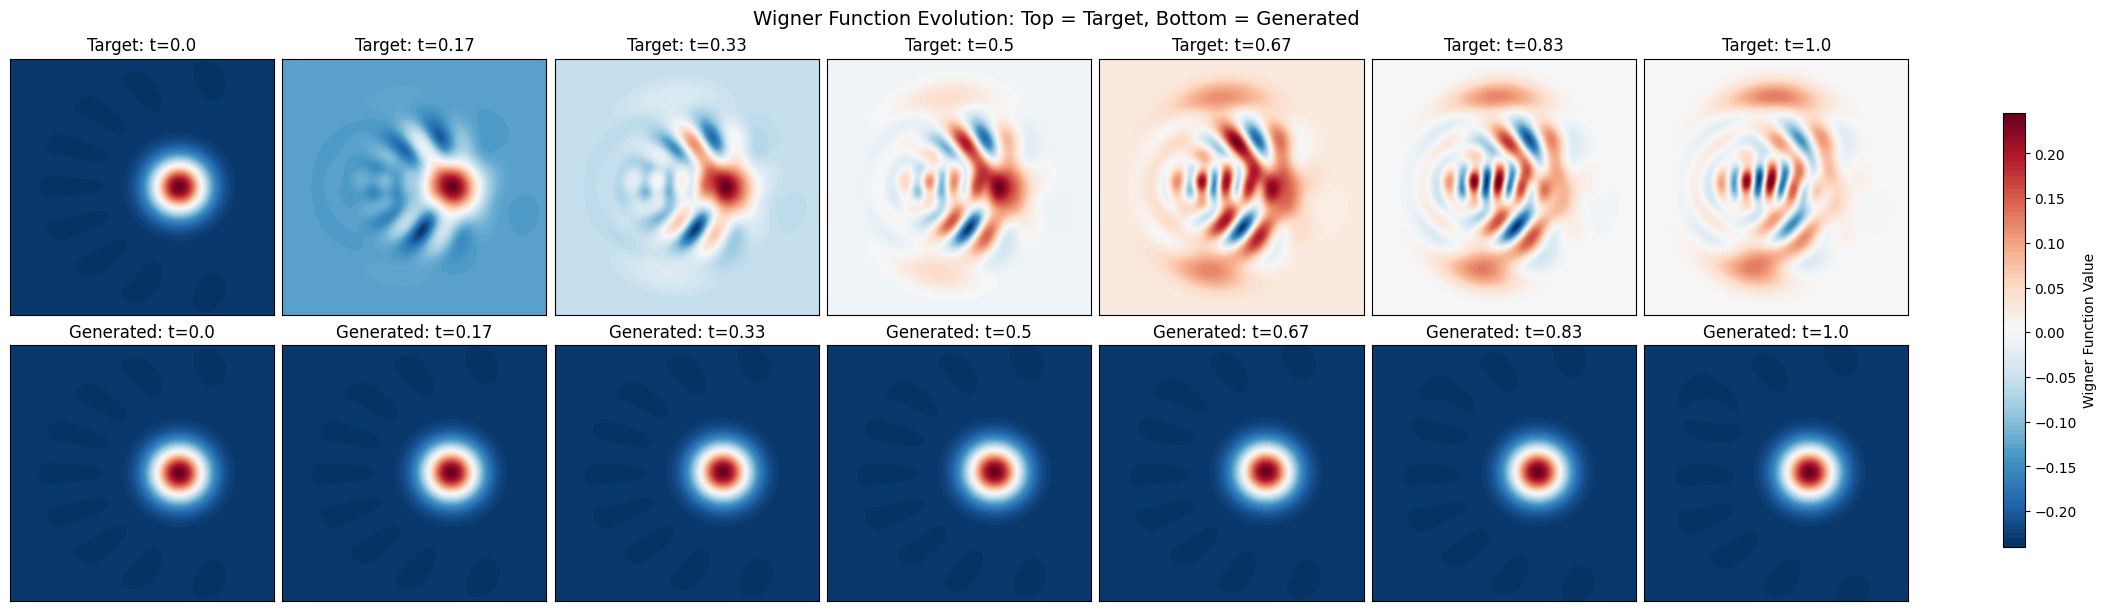

In [18]:
# Generate Wigner Function Graphics

time_and_extra = 1     # end time to be visualized for the wigner function
steps = 6              # number of steps to visualize

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
wig_init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode

# Option 1: Fock state
# wig_fock_state_index = 2
# wig_init_qumode_state = np.zeros(N, dtype=complex)
# wig_init_qumode_state[fock_state_index] = 1.0

# Option 2: Coherent state
coherent_alpha = 1.0
wig_init_qumode_state = coherent(backend.dim, coherent_alpha).full().flatten()

# --- Generate Wigner Function Visualization ---
visualization.gen_wigfunc(
    wig_init_qubit_state = wig_init_qubit_state,
    wig_init_qumode_state = wig_init_qumode_state,
    time_and_extra = time_and_extra,
    steps = steps,
    generated_hamiltonian = synthesized_hamiltonian,
    backend = backend,
    morse_to_optimize = morse_evolution 
)